In [137]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep


hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)
results = pickle.load(open("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/temporary_22082023_with_reco_frac.pkl", "rb"))
#results = pickle.load(open("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/temporary_22082023_with_reco_count_NOT_known_particles1.pkl", "rb"))
#fname = "/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/temporary_22082023_with_reco_count_known_particles1.pkl"
fname = "/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23_08_larger_DS_known_particle_ckpts/temp_ckpt.pkl"
results = pickle.load(open(fname, "rb"))
#results = pickle.load(open("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23_08_larger_DS_known_particle_ckpts/temp_ckpt.pkl", "rb"))
result = results



In [176]:
def getEffSigma(data_for_hist, percentage=0.683, bins=1000):
    bins = np.linspace(0, 200, bins+1)
    theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.01
    wmax = 5.0
    epsilon = 0.1
    point = wmin
    weight = 0.0
    points = []
    sums = []
    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)

    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            # print(wy)
            if abs(wy - percentage) < epsilon:
                # print("here")
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    # print(points[j][0], points[i][0], wy, wx)
                    width = wx
                    ii = i
                    jj = j
    # print(low, high)
    print(low, high)
    return 0.5 * (high - low), low, high


In [177]:
#results =results[0.4]
#result = results[0.4]
#result=results
result.keys()

dict_keys(['loss_e_fracs', 'loss_e_fracs_true', 'part_E_true', 'part_PID_true', 'reco_counts', 'non_reco_counts', 'total_counts'])

In [178]:
print(result["total_counts"])
print(sum(result["total_counts"].values()))

{2112: 47216.0, -211: 23168.0, 2212: 22376.0, -2212: 25431.0, 130: 55473.0, 211: 22752.0}
196416.0


In [179]:
particle_colors = {2112: "red", -211: "green", 2212: "blue", -2212: "purple", 130: "gray", 211: "orange"}


In [180]:
def divide_dicts(num, denom):
    d = {}
    for k in num.keys():
        if denom[k] == 0 or k not in denom:
            d[k] = "inf"
        else:
            d[k] = num[k] / denom[k]
    return d
res = divide_dicts(result["reco_counts"], result["total_counts"])
print("Efficiency per particle type:", res)

Efficiency per particle type: {2112: 1.0, -211: 1.0, 2212: 1.0, -2212: 1.0, 130: 1.0, 211: 1.0}


findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the followin

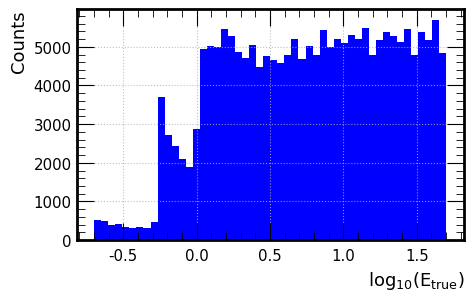

In [181]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(np.log10(result["part_E_true"]), bins=50, label="Energy true", color="blue")
#for pid in result["part_PID_true"].unique():
#    idx = [i for i, x in enumerate(result["part_PID_true"]) if x == pid]
#    ax.hist(np.log10(result["part_E_true"][idx]), bins=50, label=f"PID: {pid}", alpha=0.5, color=particle_colors[pid.item()])
ax.set_xlabel("$log_{10} (E_{true})$")
ax.set_ylabel("Counts")
ax.grid()
fig.show()
fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/24082023_plots/energy_true_distribution_more_state.pdf")

In [182]:
result["part_E_true"].max().item(), result["part_E_true"].min().item()

(50.425819396972656, 0.19988548755645752)

In [183]:
ranges = [(0.2, 1), (1, 10), (10, 50)]

In [184]:
e_frac_per_pid_and_range = {}
for pid in result["part_PID_true"].unique():
    e_frac_per_pid_and_range[pid] = {}
    for r in ranges:
        e_frac_per_pid_and_range[pid][r] = []
        idx = [i for i, x in enumerate(result["part_PID_true"]) if x == pid and result["part_E_true"][i] > r[0] and result["part_E_true"][i] <= r[1]]
        e_frac_per_pid_and_range[pid][r] = result["loss_e_fracs"][idx]
num_pids, num_ranges = len(e_frac_per_pid_and_range.keys()), len(ranges)


In [185]:
import torch
data = e_frac_per_pid_and_range[list(e_frac_per_pid_and_range.keys())[0]][ranges[0]]
getEffSigma(data, percentage=0.683, bins=300)

0.3333333333333333 1.0


(0.33333333333333337, 0.3333333333333333, 1.0)

0.3333333333333333 1.0
tensor(0.2841) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(0.9224) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(0.9988) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(0.3992) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(1.0000) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(1.0000) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(0.9985) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(1.0000) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(0.9998) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(1.0000) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(1.) (0.33333333333333337, 0.3333333333333333, 1.0)
0.3333333333333333 1.0
tensor(0.0004) (0.33333333333333337, 0.3333333

findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the followin

{(tensor(-2212), (0.2, 1)): 0.33333333333333337, (tensor(-2212), (1, 10)): 0.33333333333333337, (tensor(-2212), (10, 50)): 0.33333333333333337, (tensor(-211), (0.2, 1)): 0.33333333333333337, (tensor(-211), (1, 10)): 0.33333333333333337, (tensor(-211), (10, 50)): 0.33333333333333337, (tensor(130), (0.2, 1)): 0.33333333333333337, (tensor(130), (1, 10)): 0.33333333333333337, (tensor(130), (10, 50)): 0.33333333333333337, (tensor(211), (0.2, 1)): 0.33333333333333337, (tensor(211), (1, 10)): 0.33333333333333337, (tensor(211), (10, 50)): 0.33333333333333337, (tensor(2112), (0.2, 1)): 2.495, (tensor(2112), (1, 10)): 0.33333333333333337, (tensor(2112), (10, 50)): 0.33333333333333337, (tensor(2212), (0.2, 1)): 0.33333333333333337, (tensor(2212), (1, 10)): 0.33333333333333337, (tensor(2212), (10, 50)): 0.33333333333333337}


findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the followin

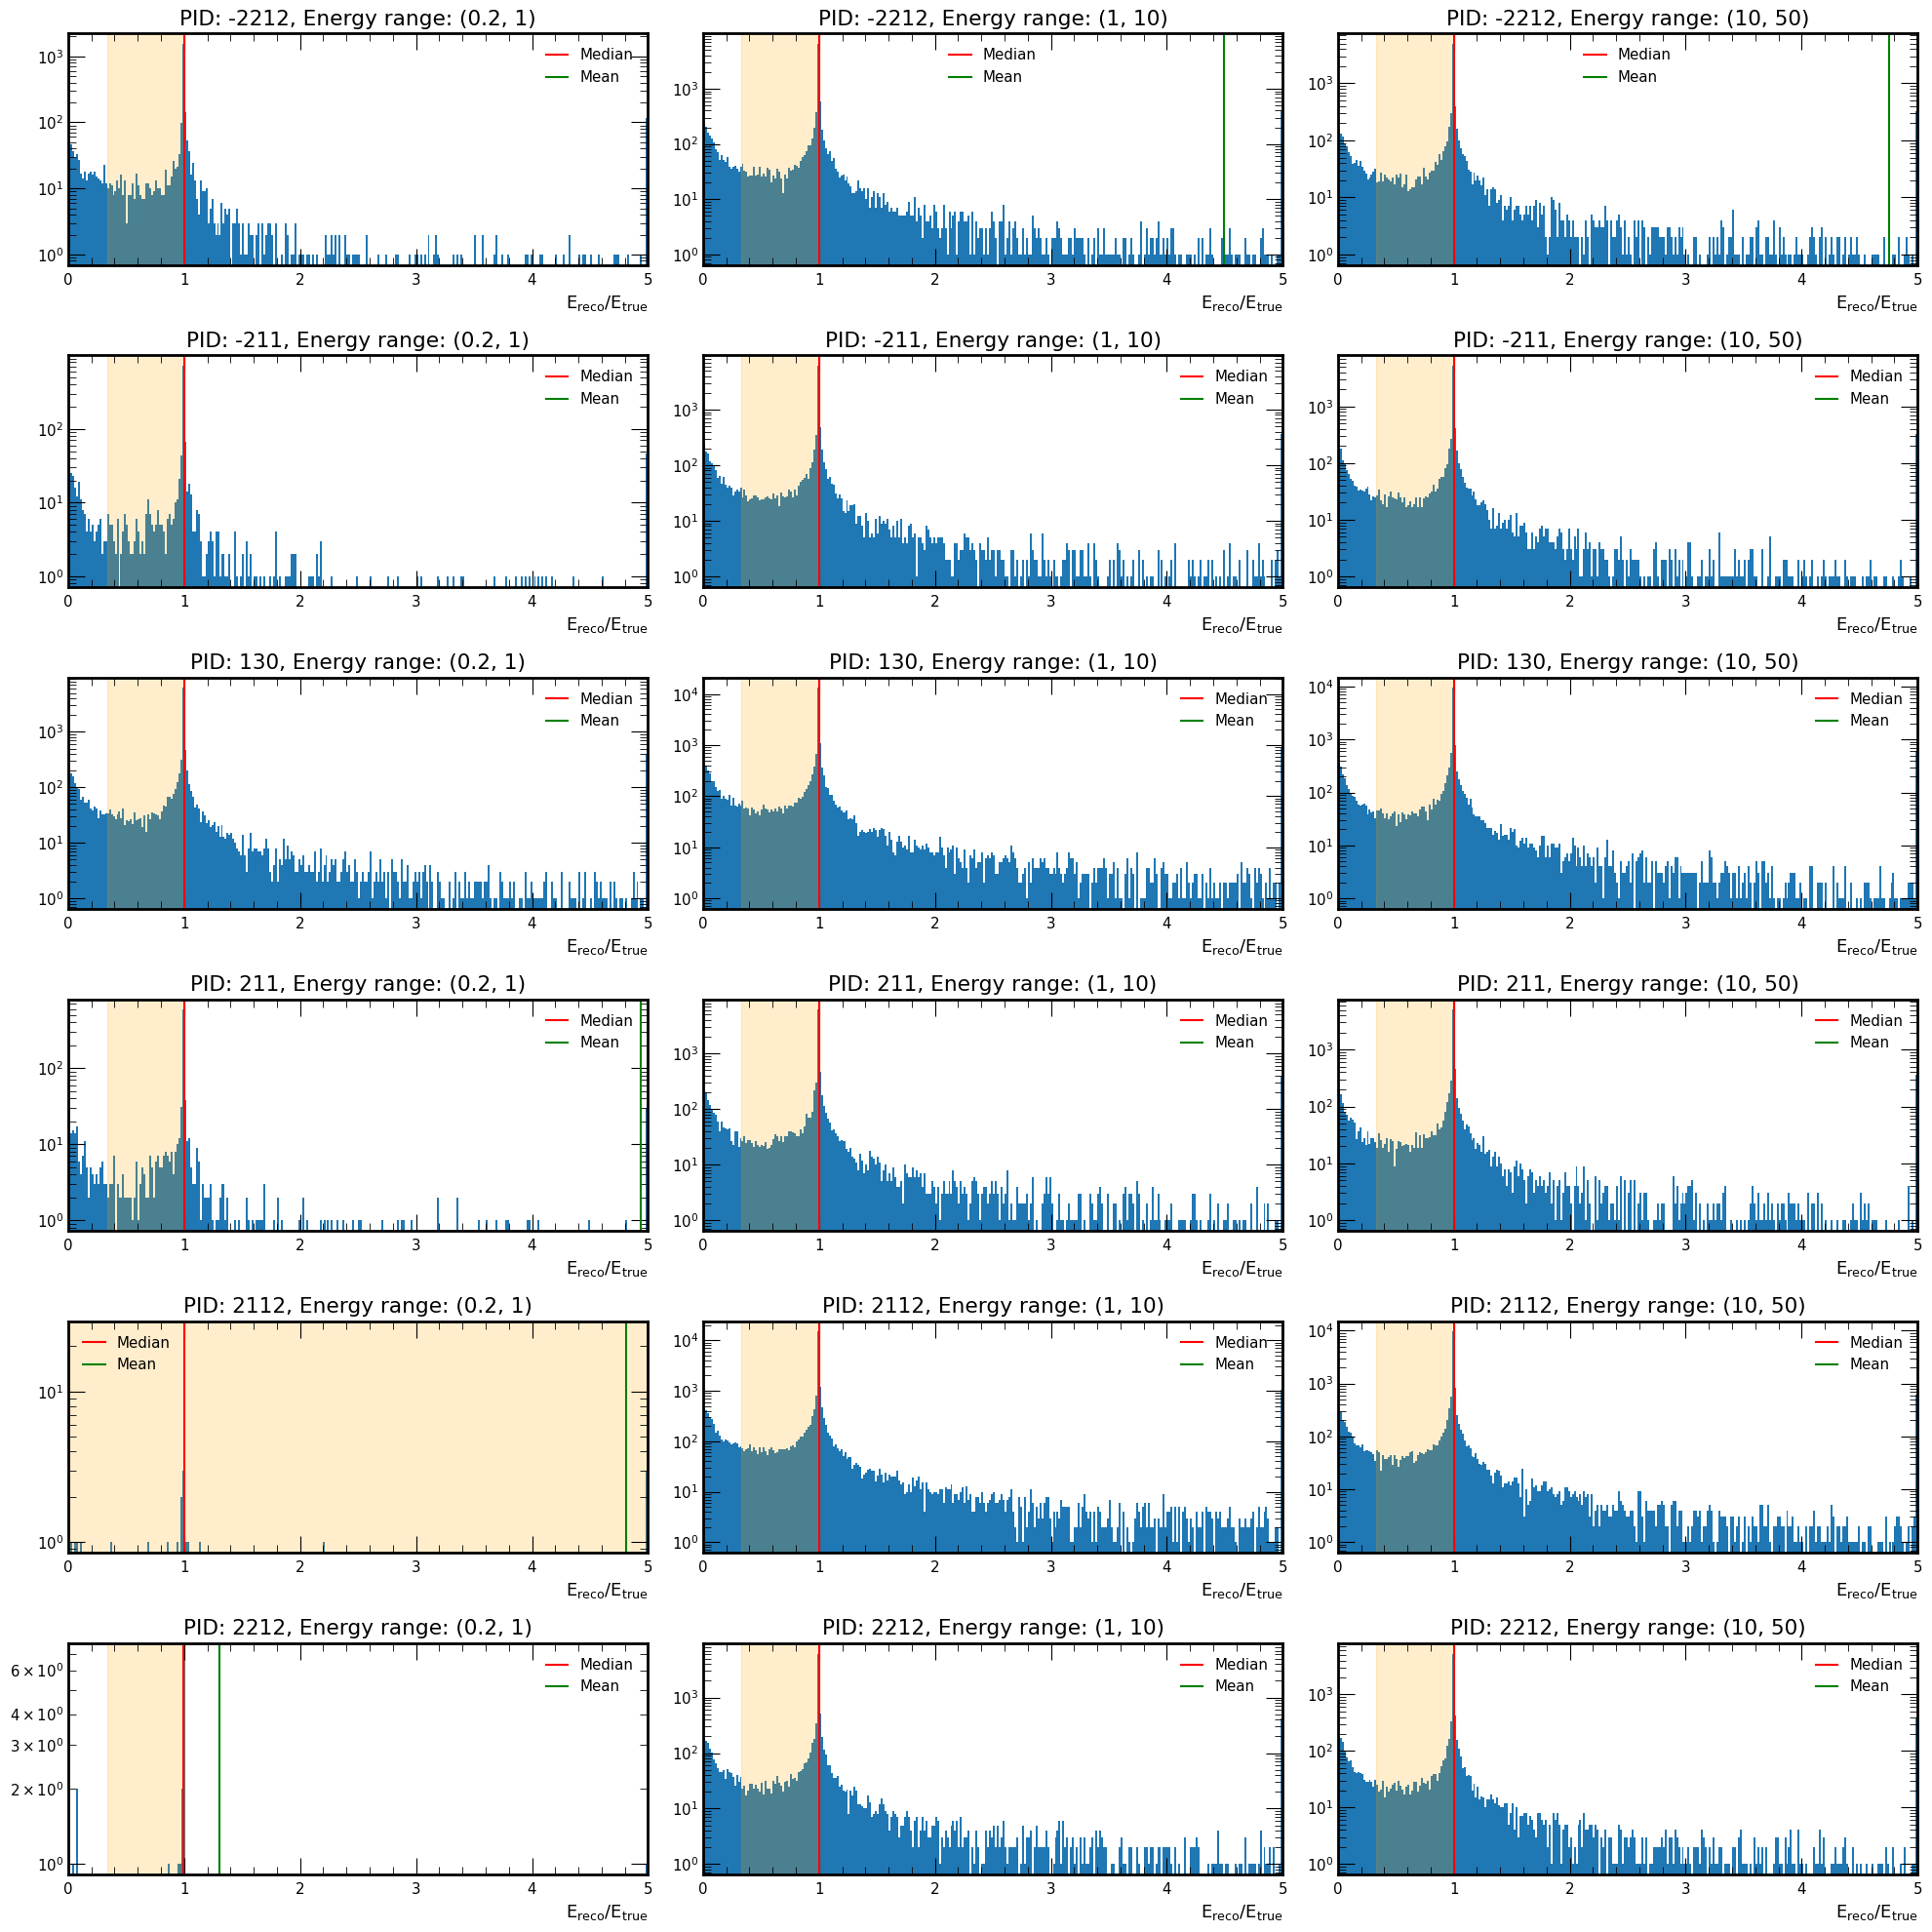

In [186]:
fig, ax = plt.subplots(num_pids, num_ranges, figsize=(20, 20))

intervals = {}
sigmas = {}

def clip(data, n):
    return [x if x < n else n for x in data]

for i, pid in enumerate(e_frac_per_pid_and_range.keys()):
    for j, r in enumerate(ranges):
        data = e_frac_per_pid_and_range[pid][r]
        if len(data):
            median, mean = data.median(), data.mean()
            interval_68 = getEffSigma(data, percentage=0.683, bins=300)
            print(data[0], interval_68)
            sigma = interval_68[0]
            interval_68 = [interval_68[1], interval_68[2]]
            data = clip(data, 5)
            ax[i, j].hist(data, bins=300, label="")
            ax[i, j].set_xlim([0, 5])
            ax[i, j].axvline(median, color="red", label="Median")
            ax[i, j].axvline(mean, color="green", label="Mean")
            ax[i, j].set_yscale("log")
            #ax[i, j].axvline(interval_68[0], color="orange", label="68% interval")
            #ax[i, j].axvline(interval_68[1], color="orange")
            # shaded 68% interval
            ax[i, j].axvspan(interval_68[0], interval_68[1], 0, 5, color="orange", alpha=0.2)
            sigmas[(pid, r)] = sigma
            intervals[(pid, r)] = interval_68
            ax[i, j].legend()
        ax[i, j].set_xlabel("$E_{reco} / E_{true}$")
        ax[i, j].set_title(f"PID: {pid}, Energy range: {r}")


fig.tight_layout()
fig.show()
fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/24082023_plots/part_plots_more_stat.pdf")
#fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23082023_plots/plot_with_known_particle_match_NOT_known_part.pdf")
print(sigmas)

[1, 10, 50] [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
[1, 10, 50] [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
[1, 10, 50] [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
[1, 10, 50] [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
[1, 10, 50] [2.495, 0.33333333333333337, 0.33333333333333337]
[1, 10, 50] [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]


findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the followin

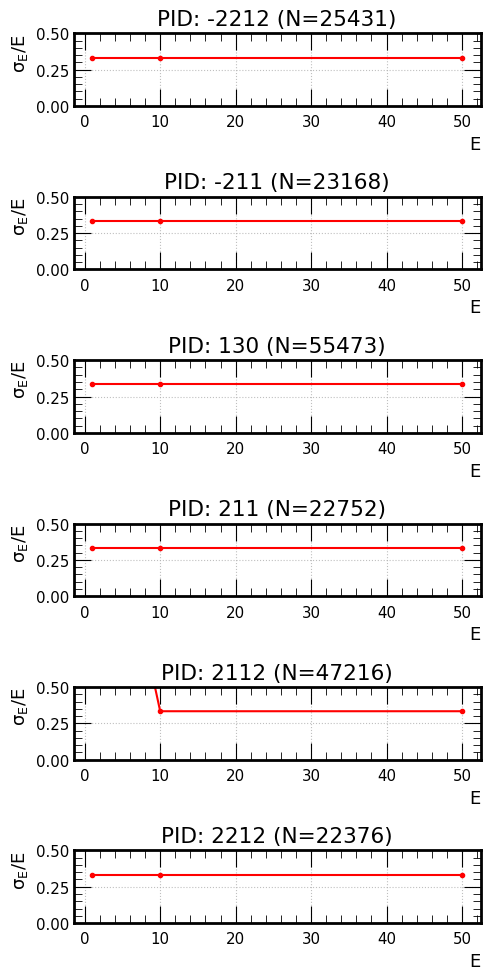

In [187]:
fig, ax = plt.subplots(num_pids, 1, figsize=(5, 10))
for i, pid in enumerate(e_frac_per_pid_and_range.keys()):
    sigmas1, energies = [], []
    #sigmas = [intervals[(pid, r)] for r in ranges]
    #energies = [r[1] for r in ranges]
    for j in range(len(ranges)):
        #print(ranges[j])
        if (pid, ranges[j]) in intervals:
            sigmas1.append(sigmas[(pid, ranges[j])])
            energies.append(ranges[j][1])
    print(energies, sigmas1)
    ax[i].plot(energies, sigmas1, ".-", color="red")
    ax[i].set_xlabel("E")
    ax[i].set_ylabel("$\sigma_E/E$")
    ax[i].set_title(f"PID: {pid} (N={sum(result['part_PID_true'] == pid)})")
    #ax[i].set_xscale("log")
    ax[i].grid()
    ax[i].set_ylim([0, 0.5])
fig.tight_layout()
fig.show()
#fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23082023_plots/sigma_vs_energy_with_known_particle_match_range.pdf")


findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: TeX Gyre Heros, Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the followin

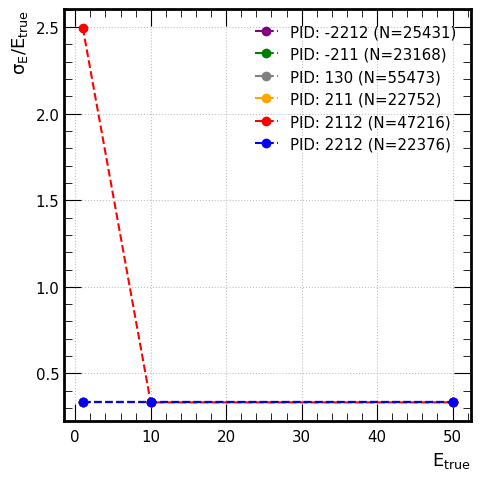

In [188]:
fig, ax = plt.subplots(figsize=(5, 5))

for i, pid in enumerate(e_frac_per_pid_and_range.keys()):
    sigmas1, energies = [], []
    for j in range(len(ranges)):
        if (pid, ranges[j]) in intervals:
            sigmas1.append(sigmas[(pid, ranges[j])])
            energies.append(ranges[j][1])
    #print(energies, sigmas)
    ax.plot(energies, sigmas1, "o--", color=particle_colors[pid.item()], label="PID: " + str(pid.item()) + " (N=" + str(sum(result['part_PID_true'] == pid).item()) + ")")
ax.set_xlabel("$E_{true}$")
ax.set_ylabel("$\sigma_E/E_{true}$")
ax.legend()
ax.grid()
#ax.set_ylim([0.35, 0.45])
fig.tight_layout()
fig.show()
fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/24082023_plots/sigma_vs_energy_eff1_morestat.pdf")


In [84]:
list(sigmas.values())

[0.2,
 0.4,
 0.4,
 0.2,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4]

In [86]:
intervals.values()

dict_values([[0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0], [0.2, 1.0]])